In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import glob
import sigpy as sp

import os, sys
import ismrmrd
import ismrmrd.xsd

/home/blevac/anaconda3/envs/cmr-data/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
# Load file
filename = '/csiNAS3/mridata/cmr_nih/00035743/Retro_Lin_Cine_2DT_LAX_GLS_000000_46461869_46461878_334_00000000-000000.h5'
if not os.path.isfile(filename):
    print("%s is not a valid file" % filename)
    raise SystemExit
dset = ismrmrd.Dataset(filename, 'dataset', create_if_needed=False)
header = ismrmrd.xsd.CreateFromDocument(dset.read_xml_header())
enc = header.encoding[0]
# Matrix size
eNx = enc.encodedSpace.matrixSize.x
eNy = enc.encodedSpace.matrixSize.y
eNz = enc.encodedSpace.matrixSize.z
rNx = enc.reconSpace.matrixSize.x
rNy = enc.reconSpace.matrixSize.y
rNz = enc.reconSpace.matrixSize.z
# Field of View
eFOVx = enc.encodedSpace.fieldOfView_mm.x
eFOVy = enc.encodedSpace.fieldOfView_mm.y
eFOVz = enc.encodedSpace.fieldOfView_mm.z
rFOVx = enc.reconSpace.fieldOfView_mm.x
rFOVy = enc.reconSpace.fieldOfView_mm.y
rFOVz = enc.reconSpace.fieldOfView_mm.z

In [18]:
print(header)

ismrmrdHeader(version=None, subjectInformation=subjectInformationType(patientName='XXXXXX', patientWeight_kg=None, patientHeight_m=None, patientID='00035743', patientBirthdate=None, patientGender='F'), studyInformation=studyInformationType(studyDate=XmlDate(1971, 1, 1), studyTime=XmlTime(0, 0, 0, 0), studyID=None, accessionNumber=None, referringPhysicianName=None, studyDescription=None, studyInstanceUID=None, bodyPartExamined=None), measurementInformation=measurementInformationType(measurementID='00000_46461869_46461878_334', seriesDate=None, seriesTime=None, patientPosition=<patientPositionType.HFS: 'HFS'>, relativeTablePosition=None, initialSeriesNumber=None, protocolName='2ch_cine_contours', sequenceName=None, seriesDescription=None, measurementDependency=[measurementDependencyType(dependencyType='SenMap', measurementID='00000_46461869_46461878_319'), measurementDependencyType(dependencyType='Noise', measurementID='00000_46461869_46461878_319')], seriesInstanceUIDRoot=None, frameOfR

In [11]:
enc = header.encoding[0]
print(enc.parallelImaging)
print(enc.trajectoryDescription)

parallelImagingType(accelerationFactor=accelerationFactorType(kspace_encoding_step_1=2, kspace_encoding_step_2=1), calibrationMode=<calibrationModeType.SEPARATE: 'separate'>, interleavingDimension=None, multiband=None)
None


In [12]:
print(dset.number_of_acquisitions())
acq_data = dset.read_acquisition(0)
num_pe = 0
for i in range(dset.number_of_acquisitions()):
    acq = dset.read_acquisition(i)
    if acq.isFlagSet(ismrmrd.ACQ_IS_NOISE_MEASUREMENT):
        print("Found noise scan at acq ", i)
        noise_data = acq.data
    if acq.isFlagSet(ismrmrd.ACQ_IS_DUMMYSCAN_DATA):
        print("Found dummy scan at acq ", i)
    elif acq.isFlagSet(ismrmrd.ACQ_IS_SURFACECOILCORRECTIONSCAN_DATA):
        print("Found surface scan at acq ", i)
    elif acq.isFlagSet(ismrmrd.ACQ_IS_PARALLEL_CALIBRATION):
        print("Found parallel cal scan at acq ", i)
    elif acq.isFlagSet(ismrmrd.ACQ_IS_PARALLEL_CALIBRATION_AND_IMAGING):
        print("Found surface parallel imaging at acq ", i)
    elif acq.isFlagSet(ismrmrd.ACQ_IS_PHASECORR_DATA):
        print("Found phase corr at acq ", i)
    else:
        num_pe = num_pe + 1
    print(i, acq.data.shape)
print(num_pe)
# print(acq_data.data.shape)

2056
Found noise scan at acq  0
0 (30, 512)
Found parallel cal scan at acq  1
1 (30, 128)
Found parallel cal scan at acq  2
2 (30, 128)
Found parallel cal scan at acq  3
3 (30, 128)
Found parallel cal scan at acq  4
4 (30, 128)
Found parallel cal scan at acq  5
5 (30, 128)
Found parallel cal scan at acq  6
6 (30, 128)
Found parallel cal scan at acq  7
7 (30, 128)
Found parallel cal scan at acq  8
8 (30, 128)
Found parallel cal scan at acq  9
9 (30, 128)
Found parallel cal scan at acq  10
10 (30, 128)
Found parallel cal scan at acq  11
11 (30, 128)
Found parallel cal scan at acq  12
12 (30, 128)
Found parallel cal scan at acq  13
13 (30, 128)
Found parallel cal scan at acq  14
14 (30, 128)
Found parallel cal scan at acq  15
15 (30, 128)
Found parallel cal scan at acq  16
16 (30, 128)
Found parallel cal scan at acq  17
17 (30, 128)
Found parallel cal scan at acq  18
18 (30, 128)
Found parallel cal scan at acq  19
19 (30, 128)
Found parallel cal scan at acq  20
20 (30, 128)
Found parallel

In [13]:
# Number of Slices, Reps, Contrasts, etc.
ncoils = header.acquisitionSystemInformation.receiverChannels
if enc.encodingLimits.slice != None:
    nslices = enc.encodingLimits.slice.maximum + 1
else:
    nslices = 1
if enc.encodingLimits.repetition != None:
    nreps = enc.encodingLimits.repetition.maximum + 1
else:
    nreps = 1
if enc.encodingLimits.contrast != None:
    ncontrasts = enc.encodingLimits.contrast.maximum + 1
else:
    ncontrasts = 1
# TODO loop through the acquisitions looking for noise scans
firstacq=0
firstcalacq=0
for acqnum in range(dset.number_of_acquisitions()):
    acq = dset.read_acquisition(acqnum)
    # TODO: Currently ignoring noise scans
    if acq.isFlagSet(ismrmrd.ACQ_IS_NOISE_MEASUREMENT):
        print("Found noise scan at acq ", acqnum)
        continue
    elif acq.isFlagSet(ismrmrd.ACQ_IS_PARALLEL_CALIBRATION):
        print('Found calibration scan at acq ', acqnum)
        Ncx = acq.data.shape[-1]
        continue
    else:
        firstacq = acqnum
        Nx = acq.data.shape[-1]
        print("Imaging acquisition starts acq ", acqnum)
        break

# Initialiaze a storage array
all_data = np.zeros((nreps, ncontrasts, nslices, ncoils, eNz, eNy, Nx), dtype=np.complex64)
print(all_data.shape)
cal_data = np.zeros((nreps, ncontrasts, nslices, ncoils, eNz, firstacq-1, Ncx), dtype=np.complex64)
print(cal_data.shape)

for acqnum in range(1, firstacq):
    acq = dset.read_acquisition(acqnum)
    rep = acq.idx.repetition
    contrast = acq.idx.contrast
    slice = acq.idx.slice
    y = acq.idx.kspace_encode_step_1
    z = acq.idx.kspace_encode_step_2
    # print(acq.data.shape)
    print(acq.data.shape)
    cal_data[rep, contrast, slice, :, z, y, :] = acq.data

# Loop through the rest of the acquisitions and stuff
for acqnum in range(firstacq,dset.number_of_acquisitions()):
    acq = dset.read_acquisition(acqnum)
    # TO`DO: this is where we would apply noise pre-whitening
    # Remove oversampling if needed
    # if eNx != rNx:
    # xline = transform.transform_kspace_to_image(acq.data, [1])
    # x0 = int((eNx - rNx) / 2)
    # x1 = int((eNx - rNx) / 2 + rNx)
    # xline = xline[:,x0:x1]
    # acq.resize(rNx,acq.active_channels,acq.trajectory_dimensions)
    # acq.center_sample = int(rNx/2)
    # # need to use the [:] notation here to fill the data
    # acq.da`ta[:] = transform.transform_image_to_kspace(xline, [1])
    # Stuff into the buffer
    rep = acq.idx.repetition
    contrast = acq.idx.contrast
    slice = acq.idx.slice
    y = acq.idx.kspace_encode_step_1
    z = acq.idx.kspace_encode_step_2
    # print(acq.data.shape)
    all_data[rep, contrast, slice, :, z, y, :] = acq.data

Found noise scan at acq  0
Found calibration scan at acq  1
Found calibration scan at acq  2
Found calibration scan at acq  3
Found calibration scan at acq  4
Found calibration scan at acq  5
Found calibration scan at acq  6
Found calibration scan at acq  7
Found calibration scan at acq  8
Found calibration scan at acq  9
Found calibration scan at acq  10
Found calibration scan at acq  11
Found calibration scan at acq  12
Found calibration scan at acq  13
Found calibration scan at acq  14
Found calibration scan at acq  15
Found calibration scan at acq  16
Found calibration scan at acq  17
Found calibration scan at acq  18
Found calibration scan at acq  19
Found calibration scan at acq  20
Found calibration scan at acq  21
Found calibration scan at acq  22
Found calibration scan at acq  23
Found calibration scan at acq  24
Found calibration scan at acq  25
Found calibration scan at acq  26
Found calibration scan at acq  27
Found calibration scan at acq  28
Found calibration scan at acq 

In [14]:
print(all_data.shape)
all_imgs = sp.ifft(all_data, axes=(-1,-2))
# squeeze all_images
all_imgs = np.squeeze(all_imgs)
print(all_imgs.shape)

(1, 1, 1, 30, 1, 194, 404)
(30, 194, 404)


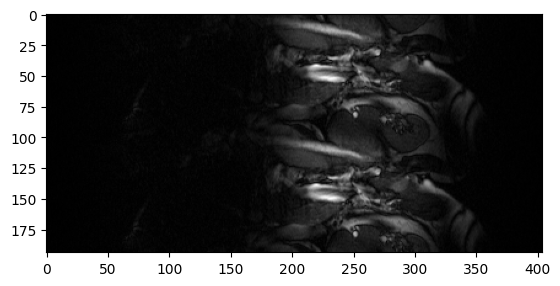

In [16]:
plt.figure()
plt.imshow(np.abs(all_imgs[0,:,:]), cmap='gray')